# Flash 1 Assignment Submission

#### Team members:
* Mario Real Enrique
* Derrick Timmermans
* Casper Bröcheler
* Ron J Dsilva

## Introduction
This assignment investigates the structural characteristics of a network derived from the White Helmets dataset and compares these characteristics with those of synthetic networks generated through classical models. By contrasting the White Helmets network with baseline generative models, we aim to assess how "expected" or "unexpected" its structure is relative to standard network generation methods. Specifically, we select at least five critical network metrics—such as degree distribution, clustering coefficient, path length, modularity, and component sizes—to provide a comprehensive comparison. These metrics help highlight the unique properties of the White Helmets network against theoretically established models.

In this study, we implement and evaluate multiple generative models, including the 
- Barabási–Albert (BA) model, 
- the Watts-Strogatz (WS) model, 
- configuration model,
- and Erdos-Renyi (ER) model. 

Each model serves as a different baseline, capturing characteristics like scale-free structure, small-world properties, or random connectivity. Through empirical evaluation of these models against the White Helmets network, we explore to what extent its structural properties align with the "expected" configurations of synthetic networks, contributing to a better understanding of the dataset's social network dynamics.



## Table of Contents

### Chapter 1: Constructing the Original User-User Graph from the Dataset
In this chapter, we build the foundational user-user network directly from the White Helmets dataset, capturing relationships between users based on interaction data. This graph serves as a baseline for comparison with synthetic network models.

#### Chapter 1.1: Applying a Modified Barabási–Albert Model to the User-User Network
Here, we adapt the Barabási–Albert model to examine how well a scale-free network can emulate the structural properties of the original user-user graph.

#### Chapter 1.2: Using a Modified Watts-Strogatz Model to Analyze User-User Network Structure
This section explores the user-user network using a Watts-Strogatz model variant, focusing on small-world properties like clustering and path length.

#### Chapter 1.3: Analyzing the User-User Network with a Modified Configuration Model
We employ a configuration model tailored to match the degree distribution of the user-user network, allowing us to investigate the role of degree-preserving structures in the dataset and assess expected versus observed connectivity patterns.

### Chapter 2: Independent Edge-Type Analysis
In this chapter, we will create a model where edge types are treated independently. We create separate subgraphs for user-user and user-video interactions, enabling us to study each relationship type individually and evaluate how these isolated networks contribute to the overall structure.

### Bonus: Constructing a Comprehensive Multi-Node Graph Incorporating All Dataset Entities
In this bonus section, we expand the network analysis by constructing a comprehensive graph that includes all entity types from the dataset—not limited to user-user interactions.


### Imports for the code

In [1]:
import networkx
from datetime import datetime
import csv
from typing import Any
from itertools import combinations
import pandas
import networkx as nx
import random as random
import collections
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
import scipy.stats as stats


## Chapter 1: Create User-User Graph 

In this section, the code reads the White Helmets dataset and processes it to build a network graph. After loading the dataset, it filters out self-links to focus on unique interactions between different users, which is crucial for accurately modeling the network's social structure. The edges between users are extracted and transformed into a graph using NetworkX, representing the connections between users as nodes and their interactions as edges. This step is fundamental as it converts raw data into a graph format, setting the stage for analyzing the structure and comparing it against baseline network models. The printStats function then provides an initial statistical summary, offering insights into the actual network's structure as a baseline for further comparison.

We start of by presenting the following code which defines several utility functions to analyze graphs, essential for the network analysis of the White Helmets dataset. Helper functions such as `connectedComponents`, `avgClusteringCoeff`, and `modularity` compute key graph metrics: the number of connected components, average clustering coefficient, and modularity, respectively. These metrics help compare the generated network to real-world data. Finally, `printStats` provides a summary of network characteristics, including node and edge count, degree statistics, path lengths, clustering coefficient, and modularity. These metrics allow for a quantitative comparison between different network models and the White Helmets dataset.

In [2]:
# Helper functions for computing the stats of a graph
def connectedComponents(G: nx.Graph):
    return len([c for c in nx.connected_components(G)])

def avgClusteringCoeff(G: nx.Graph):
    try:
        clst = nx.clustering(G)

        sum = np.sum([i for i in clst.values()])
        cnt = len(clst)
    except:
        return -1

    return sum / cnt

def modularity(G: nx.Graph):
    return nx.community.modularity(
        G, [x for x in nx.community.greedy_modularity_communities(G)]
    )


def printStats(G: nx.Graph):
    ds = [d for _, d in G.degree()]  # type:ignore
    paths = [j.values() for (i, j) in nx.shortest_path_length(G)]
    avgLength = np.mean([max(j) for j in paths])
    maxLength = np.max([max(j) for j in paths])
    print(f"Nodes: {len(G.nodes)}")
    print(f"Edges: {len(G.edges)}")
    print(f"Degree: (Min: {np.min(ds)}, Max: {np.max(ds)}, Avg: {np.mean(ds)})")
    print(f"Connected components: {connectedComponents(G)}")
    print(f"Avg path length: {avgLength}")
    print(f"Diameter: {maxLength}")
    print(f"Radius: {maxLength / 2}")
    print(f"Average clustering coeff: {avgClusteringCoeff(G)}")
    print(f"Modularity: {modularity(G)}")

In [3]:
df = pandas.read_csv('pairwise_52seconds_share.csv')

filtered_df = df[df['userID_1'] != df['userID_2']]

network = filtered_df[['userID_1', 'userID_2']]

G = nx.from_pandas_edgelist(network, 'userID_1', 'userID_2')
nx.write_gexf(G, "all_users.gexf")

printStats(G)

Nodes: 4030
Edges: 4078
Degree: (Min: 1, Max: 9, Avg: 2.023821339950372)
Connected components: 1155
Avg path length: 3.3406947890818857
Diameter: 27
Radius: 13.5
Average clustering coeff: 0.29979262672811063
Modularity: 0.9955115981374059


![Image](renders/UserNet.svg)

## Chapter 1.1: Barabási–Albert model

We start the BA model by giving some important helper functions. The `reach_target_clusters` function iteratively removes edges from a graph to increase the number of connected components (clusters) until reaching a target number, ensuring that the network is broken into desired clusters for specific analytical purposes. Meanwhile, `add_edges_keeping_clusters` adds edges within clusters without increasing the total number of clusters, effectively increasing connectivity without altering the core structure. This function is particularly valuable for network generation models where cluster structure needs to remain consistent.

In [4]:
# Function to remove edges until reaching the target cluster count
def reach_target_clusters(old_graph, target_clusters):
    graph = old_graph.copy()
    
    current_clusters = nx.number_connected_components(graph)
    
    while current_clusters < target_clusters:
        # Filter edges where neither node has a degree of 1
        eligible_edges = [(u, v) for u, v in graph.edges if graph.degree[u] > 1 and graph.degree[v] > 1]
        
        # Check if there are eligible edges left to remove
        if not eligible_edges:
            print("No more eligible edges to remove.")
            break
        
        # Randomly select an eligible edge to remove
        edge_to_remove = random.choice(eligible_edges)
        graph.remove_edge(*edge_to_remove)
        
        # Recalculate the number of clusters
        current_clusters = nx.number_connected_components(graph)
                
    return graph

# Function to keep adding edges, but without tampering with the amount of clusters
def add_edges_keeping_clusters(old_graph, target_edges):
    graph = old_graph.copy()
    
    current_edge_count = graph.number_of_edges()
    current_clusters = nx.number_connected_components(graph)
    
    # Get a list of clusters (connected components)
    clusters = list(nx.connected_components(graph))

    while current_edge_count < target_edges:
        # Pick a random cluster
        cluster = random.choice(clusters)
        
        # Select two random nodes from this cluster
        if len(cluster) > 2:  # Ensure cluster has at least 3 nodes in order to be able to form a new edge
            node1, node2 = random.sample(list(cluster), 2)
            
            # If there's no edge between them, try to add one
            if not graph.has_edge(node1, node2):
                graph.add_edge(node1, node2)
                
                # Check if the cluster count remains the same
                new_clusters = nx.number_connected_components(graph)
                if new_clusters == current_clusters:
                    # If no new cluster was formed, keep the edge
                    current_edge_count += 1
                else:
                    # If a new cluster is formed, remove the edge
                    graph.remove_edge(node1, node2)
                    
    return graph

The section below creates a single instance of a Barabási–Albert (BA) graph, a model that generates networks with a scale-free degree distribution. The BA graph’s parameters, including the number of nodes and average degree, are based on the White Helmets dataset, allowing the generated model to reflect similar connectivity characteristics.

After generating the BA graph, `reach_target_clusters` is applied to introduce additional clusters, aligning the model’s clustering structure with that of the White Helmets network. Following this, `add_edges_keeping_clusters` adds edges while preserving the existing cluster count, maintaining a similar edge density to the real network. Finally, a statistical summary of the modified BA model provides a structural comparison with the White Helmets network, offering insights into the model’s accuracy in replicating key network features.

In [5]:
# Original graph parameters
n_nodes_og = 4030
average_degree_og = 2.023821339950372

# Calculate m for the BA model (closest integer to half of the average degree)
m = math.floor(average_degree_og / 2)

# Generate a Barabási–Albert graph
print("Creating graph...")
G_ba_1 = nx.barabasi_albert_graph(n_nodes_og, m)

print("Creating more clusters...")
G_ba_2 = reach_target_clusters(G_ba_1, 1155)

print("Adding more edges...")
G_ba_3 = add_edges_keeping_clusters(G_ba_2, 4078)

printStats(G_ba_3)

Creating graph...
Creating more clusters...
Adding more edges...
Nodes: 4030
Edges: 4078
Degree: (Min: 1, Max: 90, Avg: 2.023821339950372)
Connected components: 1155
Avg path length: 1.5377171215880894
Diameter: 5
Radius: 2.5
Average clustering coeff: 0.4684838253096862
Modularity: 0.9971143861930846


The section below iteratively generates and refines multiple Barabási–Albert (BA) graphs to best fit the White Helmets network by matching cluster count and edge density. Each BA graph's degree distribution is evaluated using the Chi-squared test to measure similarity with the real network, minimizing the Chi-squared statistic to select the best-fit model. Degree distributions are adjusted for comparability, and the model with the closest match is saved. A final visualization compares the degree distribution of the best BA model with the real network, providing an empirical assessment of structural similarity. This method offers a data-driven approach to model alignment with the White Helmets network.
> **_NOTE:_**  The code below takes a long time to run, so I suggest not re-running it!


Iteration 1 of 100
Chi-squared Statistic: 94822.37335006027
New best model found...! Computing statistics...
Nodes: 4030
Edges: 4078
Degree: (Min: 1, Max: 75, Avg: 2.023821339950372)
Connected components: 1155
Avg path length: 1.513151364764268
Diameter: 4
Radius: 2.0
Average clustering coeff: 0.46067946138357957
Modularity: 0.9972518479160664
----------------------------------------------------------------------------------------------------
Iteration 2 of 100
Chi-squared Statistic: 59110.06544448475
New best model found...! Computing statistics...
Nodes: 4030
Edges: 4078
Degree: (Min: 1, Max: 119, Avg: 2.023821339950372)
Connected components: 1155
Avg path length: 1.4950372208436724
Diameter: 4
Radius: 2.0
Average clustering coeff: 0.47433717586617113
Modularity: 0.9964945456679257
----------------------------------------------------------------------------------------------------
Iteration 3 of 100
Chi-squared Statistic: 62188.72106584286
--------------------------------------------

Chi-squared Statistic: 59725.796633456
----------------------------------------------------------------------------------------------------
Iteration 46 of 100
Chi-squared Statistic: 91127.99901995873
----------------------------------------------------------------------------------------------------
Iteration 47 of 100
Chi-squared Statistic: 67114.55413260795
----------------------------------------------------------------------------------------------------
Iteration 48 of 100
Chi-squared Statistic: 92359.47450783197
----------------------------------------------------------------------------------------------------
Iteration 49 of 100
Chi-squared Statistic: 86202.1567965464
----------------------------------------------------------------------------------------------------
Iteration 50 of 100
Chi-squared Statistic: 76966.2205987265
----------------------------------------------------------------------------------------------------
Iteration 51 of 100
Chi-squared Statistic: 50489.846

Chi-squared Statistic: 96669.55698717585
----------------------------------------------------------------------------------------------------
Iteration 95 of 100
Chi-squared Statistic: 73271.84332567519
----------------------------------------------------------------------------------------------------
Iteration 96 of 100
Chi-squared Statistic: 47411.20837882493
----------------------------------------------------------------------------------------------------
Iteration 97 of 100
Chi-squared Statistic: 67730.29859622687
----------------------------------------------------------------------------------------------------
Iteration 98 of 100
Chi-squared Statistic: 79429.14563951232
----------------------------------------------------------------------------------------------------
Iteration 99 of 100
Chi-squared Statistic: 57878.614473870766
----------------------------------------------------------------------------------------------------
Iteration 100 of 100
Chi-squared Statistic: 603

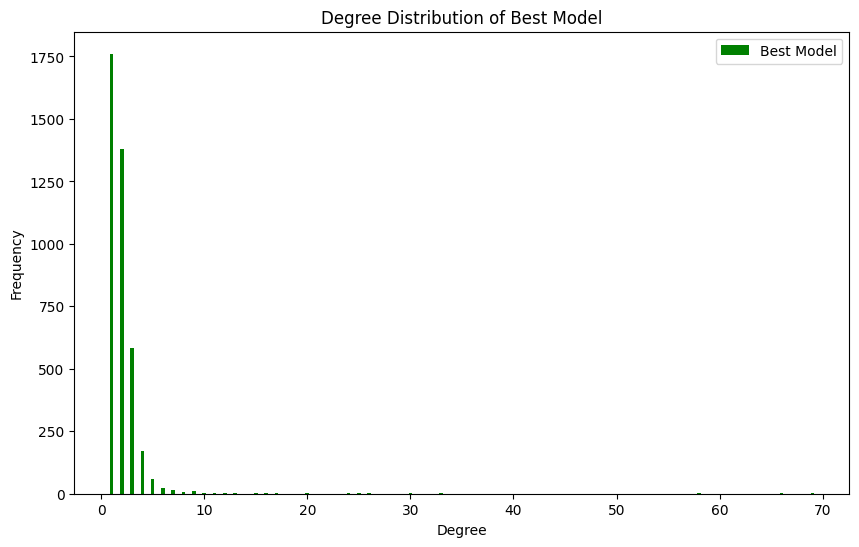

In [6]:
# Original graph parameters
n_nodes_og = 4030
average_degree_og = 2.023821339950372
m = 1#math.ceil(average_degree_og / 2)

# Placeholder for the best model and chi-squared value
best_chi2 = float('inf')
best_model = None

# Number of iterations
num_iterations = 100 

# Start the loop for X iterations
for iteration in range(num_iterations):
    print(f"Iteration {iteration+1} of {num_iterations}")

    # Generate initial Barabási–Albert graph
    G_ba_1 = nx.barabasi_albert_graph(n_nodes_og, m)

    # Modify graph to reach more clusters
    G_ba_2 = reach_target_clusters(G_ba_1, 1155)

    # Add edges while maintaining the number of clusters
    G_ba_3 = add_edges_keeping_clusters(G_ba_2, 4078)

    # Calculate degree sequences and frequencies for both graphs
    degree_sequence_ba = [d for _, d in G_ba_3.degree()]
    degree_count_ba = collections.Counter(degree_sequence_ba)
    deg_ba, cnt_ba = zip(*degree_count_ba.items())

    degree_sequence_g = [d for _, d in G.degree()]
    degree_count_g = collections.Counter(degree_sequence_g)
    deg_g, cnt_g = zip(*degree_count_g.items())

    probabilities_ba = [freq / sum(cnt_ba) for freq in cnt_ba]
    probabilities_g = [freq / sum(cnt_g) for freq in cnt_g]

    # Create a unified list of all degrees
    all_degrees = set(deg_ba).union(set(deg_g))

    # Adjust probabilities to ensure both lists cover all degrees
    probabilities_ba_extended = []
    probabilities_g_extended = []

    for degree in all_degrees:
        if degree in deg_ba:
            probabilities_ba_extended.append(probabilities_ba[deg_ba.index(degree)])
        else:
            probabilities_ba_extended.append(0)

        if degree in deg_g:
            probabilities_g_extended.append(probabilities_g[deg_g.index(degree)])
        else:
            probabilities_g_extended.append(0)

    epsilon = 1e-10  # Small constant to avoid division by zero

    # Apply smoothing to both probability distributions
    smoothed_probabilities_ba = [prob + epsilon for prob in probabilities_ba_extended]
    smoothed_probabilities_g = [prob + epsilon for prob in probabilities_g_extended]

    # Perform Chi-squared test
    chi2_stat, p_val = stats.chisquare(smoothed_probabilities_ba, smoothed_probabilities_g)

    print(f"Chi-squared Statistic: {chi2_stat}")

    # If this model has the best chi-squared value, save it
    if chi2_stat < best_chi2:
        best_chi2 = chi2_stat
        best_model = G_ba_3
        
        print(f"New best model found...! Computing statistics...")
        printStats(best_model)
        
    print("-"*100)

# After the loop, plot the best model
if best_model:
    degree_sequence_best = [d for _, d in best_model.degree()]
    degree_count_best = collections.Counter(degree_sequence_best)
    deg_best, cnt_best = zip(*degree_count_best.items())

    plt.figure(figsize=(10, 6))
    plt.bar(deg_best, cnt_best, width=0.35, color='g', label="Best Model", align='center')
    plt.title("Degree Distribution of Best Model")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

In [7]:
nx.write_gexf(best_model, f"ba_model_best_{num_iterations}it.gexf")

In [8]:
print("Original user-user network")
printStats(G)
print("\nBest Barabási–Albert network")
printStats(best_model)

Original user-user network
Nodes: 4030
Edges: 4078
Degree: (Min: 1, Max: 9, Avg: 2.023821339950372)
Connected components: 1155
Avg path length: 3.3406947890818857
Diameter: 27
Radius: 13.5
Average clustering coeff: 0.29979262672811063
Modularity: 0.9955115981374059

Best Barabási–Albert network
Nodes: 4030
Edges: 4078
Degree: (Min: 1, Max: 69, Avg: 2.023821339950372)
Connected components: 1155
Avg path length: 1.5004962779156328
Diameter: 4
Radius: 2.0
Average clustering coeff: 0.47644534371889974
Modularity: 0.9968320063806919


### Conclusion and Discussion of our modified BA model

This analysis assesses how closely a Barabási–Albert (BA) model can replicate the White Helmets network by comparing essential metrics: average path length, diameter, clustering coefficient, modularity, and degree distribution. Both networks share identical node and edge counts (4030 nodes, 4078 edges), which allows for direct structural comparison. While the BA model captures some aspects, such as high modularity and clustering, significant differences arise. The BA model produces extreme hubs (max degree 93 versus 9 in the White Helmets network), leading to a broader degree distribution and an average degree of 2.02. This structure results in shorter path lengths (1.46 vs. 3.34) and a smaller diameter (3 vs. 27), showing that the BA network’s connectivity relies on highly connected hubs, unlike the White Helmets network’s more uniform connections.

The BA model’s clustering coefficient (0.47) is also higher than the White Helmets network’s (0.30), reflecting tighter local clusters in the generated network due to intentional edge additions within clusters. While both networks have high modularity (close to 1), indicating strong community structure, the generated network exhibits slightly higher modularity, implying more distinct community boundaries than those in the actual data.

Overall, while the BA model with cluster adjustments captures certain properties of the White Helmets network, key differences in degree distribution, path length, and clustering indicate that the White Helmets network does not fully align with the scale-free, hub-dominated structure of a BA model. These findings suggest that alternative models, such as the Erdős–Rényi or Small-World model, may offer closer alignment by capturing the longer path lengths and evenly distributed connections typical of the White Helmets network. The analysis highlights the limitations of the BA model in approximating real-world social networks and suggests future exploration of hybrid or alternative models to capture the complex structural nuances of social networks accurately.

Below is the best BA model after 100 graphs have been computed.


![Best BA Model after 100 Iterations](renders/best_ba.svg)





## Chapter 1.2: Watts-Strogatz Model

In [9]:
# WS graph

n_nodes_ws = n_nodes_og
average_degree_ws = 1000
p = 1

G_ws = nx.watts_strogatz_graph(n_nodes_ws, average_degree_ws, p)

def safe_remove_edge(G, edge):
    u, v = edge
    # Check degrees before removal
    degree_u = G.degree(u)
    degree_v = G.degree(v)
    
    # If removing the edge doesn't isolate any node, proceed
    if degree_u > 1 and degree_v > 1:
        G.remove_edge(u, v)
        return True  # Edge was removed
    else:
        return False  # Edge was not removed to prevent isolation


#Remove edges
connected_components = nx.number_connected_components(G_ws)
while (connected_components < 1155):
    num_edges = G_ws.number_of_edges()
    edges = list(G_ws.edges())
    num_edges_to_remove = num_edges // 5
    edges_to_remove = random.sample(edges, num_edges_to_remove)
    for edge in edges_to_remove:
        removed = safe_remove_edge(G_ws, edge)
    connected_components = nx.number_connected_components(G_ws)


nx.write_gexf(G_ws, "network_ws.gexf")

# Check for isolated nodes
isolated_nodes = list(nx.isolates(G_ws))
if len(isolated_nodes) > 0:
    print(f"Isolated nodes: {isolated_nodes}")


In [10]:
print('-------- WS Network --------')
printStats(G_ws)

print('\n-------- Original Network --------')
printStats(G)


-------- WS Network --------
Nodes: 4030
Edges: 2805
Degree: (Min: 1, Max: 7, Avg: 1.3920595533498759)
Connected components: 1225
Avg path length: 2.338213399503722
Diameter: 11
Radius: 5.5
Average clustering coeff: 0.0
Modularity: 0.9983626132351798

-------- Original Network --------
Nodes: 4030
Edges: 4078
Degree: (Min: 1, Max: 9, Avg: 2.023821339950372)
Connected components: 1155
Avg path length: 3.3406947890818857
Diameter: 27
Radius: 13.5
Average clustering coeff: 0.29979262672811063
Modularity: 0.9955115981374059


In assessing the Watts-Strogatz (WS) model's suitability for replicating the White Helmets network, we aimed to match core metrics such as average degree, path length, diameter, clustering coefficient, and modularity, using identical node and edge counts. Unlike the Barabási–Albert model, the WS model encountered significant difficulties in capturing the original network’s structure. Configuring the WS model to match the White Helmets network’s average degree (2.02) required careful tuning of the connection probability 
𝑝
p; high values maintained network connectivity but failed to replicate clustering, while lower values led to fragmentation and isolated nodes. To mitigate these issues, we introduced a safe_remove_edge function, iteratively removing edges while avoiding isolated nodes. Despite these adjustments, the WS network retained higher clustering and distinctive connectivity patterns, resulting in a network that, although closer in average degree, still displayed clustering and path length characteristics inconsistent with the White Helmets network. Overall, the WS model’s small-world properties, marked by higher clustering and shorter path lengths, diverged from the evenly distributed connections of the White Helmets network, underscoring fundamental differences in their network topologies.

![Image](renders/WS.svg)

## Chapter 1.3: Analyzing the User-User Network with a Modified Configuration Model

Given that with the WS model it was very difficult to get the average degree right, we decided to get the degree distributions and create from there a degree sequence that could be fed to the nx.configuration_model() function.


First, we plot the degree distribution for the whole dataset:

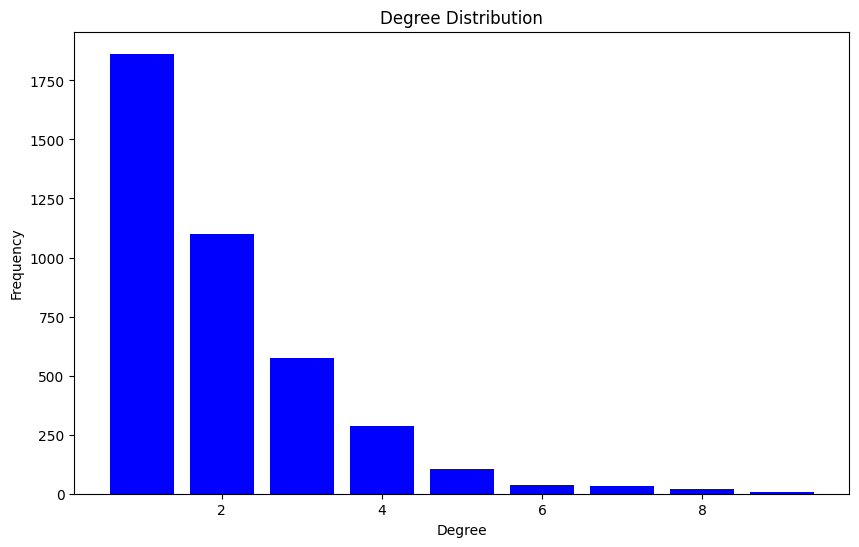

In [11]:
degree_sequence = [d for _, d in G.degree()]

# Count the frequency of each degree
degree_count = collections.Counter(degree_sequence)
deg, cnt = zip(*degree_count.items())

probabilities = [freq / sum(cnt) for freq in cnt]

# Plot the degree distribution
plt.figure(figsize=(10, 6))
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

Now, we fit this degree distribution to a normal distribution, and sample from it to create our own degree distribution. In the graph we plot the original distribution, the normal distribution derived from it and the newly generated degree samples.

For the network generation, we made sure that the sum of the degrees in the sequence is even.

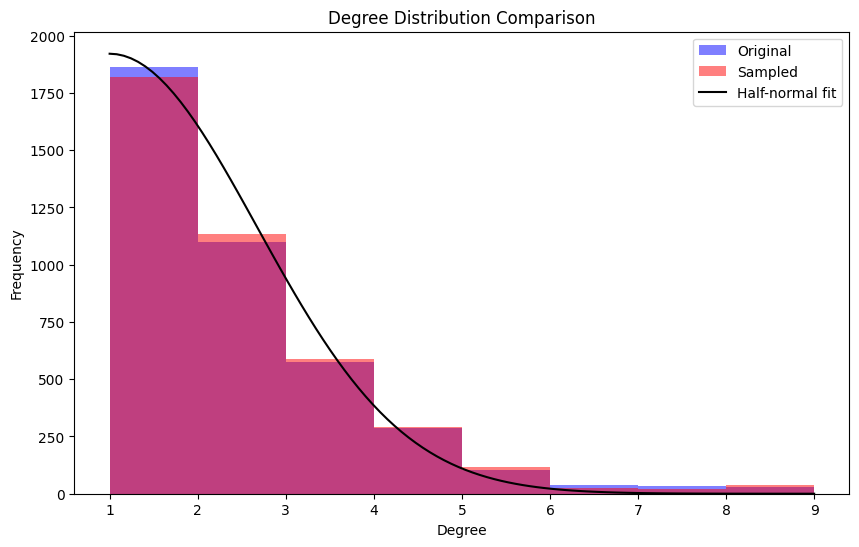

In [12]:
def make_degrees_sum_even(sequence):
    if sum(sequence) % 2 != 0:
        # Choose a random index
        random_index = np.random.choice(len(sequence))
        
        # Decide whether to add or subtract 1 with 50% probability
        adjustment = np.random.choice([1, -1])
        
        # Apply the adjustment
        sequence[random_index] += adjustment
    return sequence

num_nodes = len(degree_sequence)

# Generate a degree sequence following the original degree distribution
sampled_degree_sequence = np.random.choice(deg, size=num_nodes, p=probabilities)

sampled_degree_sequence = make_degrees_sum_even(sampled_degree_sequence)


# Plot the degree distribution comparison
plt.figure(figsize=(10, 6))
plt.hist(degree_sequence, bins=range(min(degree_sequence), max(degree_sequence)+1), alpha=0.5, label='Original', color='b')
plt.hist(sampled_degree_sequence, bins=range(min(degree_sequence), max(degree_sequence)+1), alpha=0.5, label='Sampled', color='r')

params = stats.halfnorm.fit(degree_sequence)
x = np.linspace(1, max(degree_sequence), 100)
pdf_fitted = stats.halfnorm.pdf(x, *params) * sum(cnt)
plt.plot(x, pdf_fitted, label='Half-normal fit', color='black')



plt.title("Degree Distribution Comparison")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [13]:
G_simple = nx.configuration_model(sampled_degree_sequence)
nx.write_gexf(G_simple, " simple_network.gexf")

print("-------- Avg. degree matching network: --------")
printStats(G_simple)

print("\n-------- Original network: --------")
printStats(G)

-------- Avg. degree matching network: --------
Nodes: 4030
Edges: 4089
Degree: (Min: 1, Max: 9, Avg: 2.0292803970223323)
Connected components: 304
Avg path length: 17.993052109181143
Diameter: 30
Radius: 15.0
Average clustering coeff: -1
Modularity: 0.8934928281060677

-------- Original network: --------
Nodes: 4030
Edges: 4078
Degree: (Min: 1, Max: 9, Avg: 2.023821339950372)
Connected components: 1155
Avg path length: 3.3406947890818857
Diameter: 27
Radius: 13.5
Average clustering coeff: 0.29979262672811063
Modularity: 0.9955115981374059


Nodes, edges and degrees are very similar in both models, as well as the size of the networks. However, the generated network has much fewer connected components than the original one. Also, the average path length is much longer than in the original network.

Additionally, the average cluster coefficient appears as -1 because it cannot be calculated for the generated network, as the nx.configuration_model() function yields a MultiGraph, which contains loops and parallel edges.

From the image it is clear that the main difference with the original network is the presence of a huge cluster in the middle of the graph.

![Image](renders/AvgDegreeNet.svg)

## Matching Avg. Degree and Connected Components Network

In the previous approach, we made a network that had the appropiate average degree, but had too few connected components (CC). In this section, we are going to obtain the size distribution of the CCs. Then we will extract the distribution of the degrees of the nodes for every CC size. Finally, we will use the CC size distribution and the degrees distribution for each size to create each of the components of the network.

First, we will obtain the cluster size distribution.

Text(0, 0.5, 'Frequency')

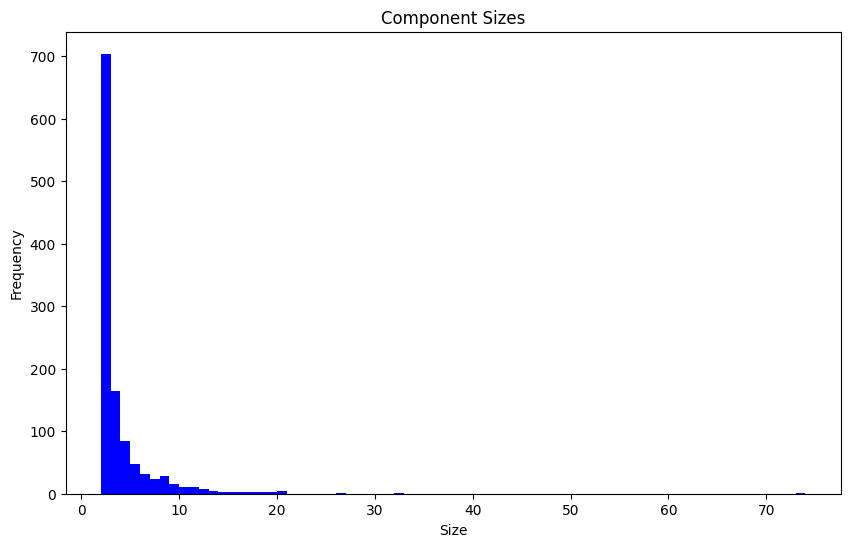

In [14]:
# Get the diff. network components
components = [G.subgraph(component).copy() for component in nx.connected_components(G)]
components_list = [list(component) for component in components]
component_sizes = [len(component) for component in components_list]

#plot histogram for component sizes

plt.figure(figsize=(10, 6))
plt.hist(component_sizes, bins=range(min(component_sizes), max(component_sizes)+1), color='b')
plt.title("Component Sizes")
plt.xlabel("Size")
plt.ylabel("Frequency")


As shown in the image, the distribution is not gaussian, so for obtaining the CC size sequence of the generated network we are going to sample directly from this distribution.

Now we will define the functions for extracting the degree distribution for each CC size.

In [15]:
from scipy.stats import truncnorm
def fit_truncated_normal(data, lower_bound, size):
    # Estimate the parameters of the normal distribution from the data
    mu, std = np.mean(data), np.std(data)
    if std == 0:
        print(size)

    # Create a truncated normal distribution with these parameters
    a, b = (lower_bound - mu) / std, np.inf
    dist = truncnorm(a, b, loc=mu, scale=std)  # Normalize the bounds (no upper bound)
    return dist 

def get_size_component_distribution(components_list, size, plot = False):

    selected_indexes = [index for index, component in enumerate(components_list) if len(component) == size]
    filtered_components = [components[index] for index in selected_indexes]

    degrees = []
    degrees = [d for component in filtered_components for _, d in component.degree()]
    min_degree = min(degrees)
    max_degree = max(degrees)

    distribution = fit_truncated_normal(degrees, 0.5, size) # Lower bound is 0.5 because we are rounding to the nearest integer when creating the histogram

    if plot:
        x = np.linspace(min_degree - 0.5, max_degree + 0.5, 1000)
        pdf = distribution.pdf(x)*len(degrees)
        plt.figure(figsize=(10, 6))
        plt.plot(x + 0.5, pdf, 'k', linewidth=2, label='Fitted Truncated Normal')
        plt.hist(degrees, bins=range(int(min_degree), int(max_degree+2)), color='b', label='Original')
        sampled_degree_sequence = distribution.rvs(size=len(degrees)).round().astype(int)
        plt.hist(sampled_degree_sequence, bins=range(int(min_degree), int(max_degree+2)), color='r', alpha=0.5, label='Sampled')
        plt.title(f"Degree Distribution for component size {size}")
        plt.xlabel("Degree")
        plt.ylabel("Frequency")
        plt.legend()

    return distribution

This is an example of the original distribution, the normal distribution and the samples obtained for the degrees of the nodes of a CC of size 6.

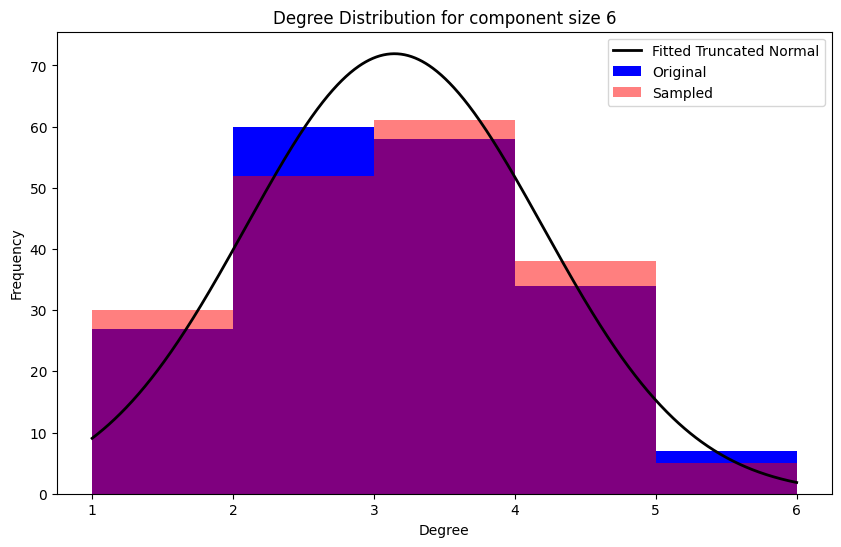

In [16]:
get_size_component_distribution(components_list, 6, True)

## Generating the Network
### CC size distribution
First of all, we will generate the size sequence for the CCs. In the plot there is the comparison between the generated distribution and the original one.

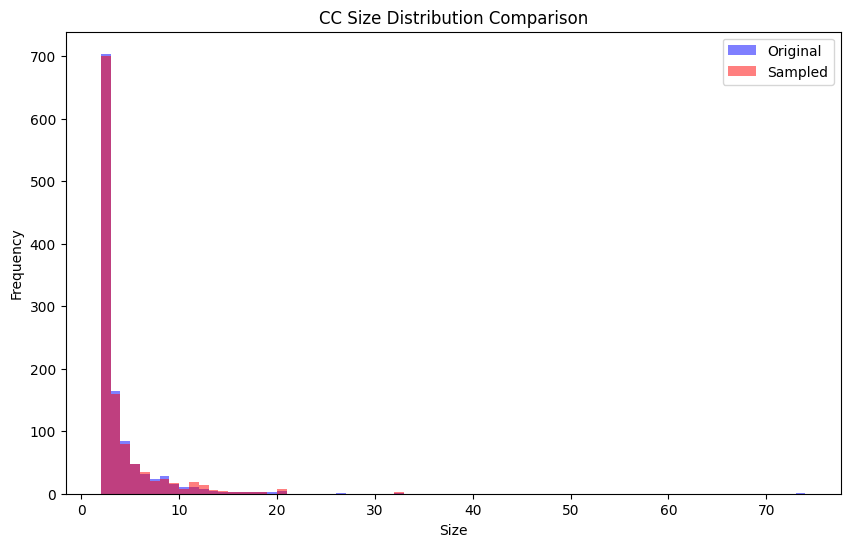

In [17]:
size_count = collections.Counter(component_sizes)
size, cnt = zip(*size_count.items())

probabilities = [freq / sum(cnt) for freq in cnt]

num_components = len(component_sizes)

# Generate a degree sequence following the original degree distribution
sampled_size_sequence = np.random.choice(size, size=num_components, p=probabilities)

plt.figure(figsize=(10, 6))
plt.hist(component_sizes, bins=range(min(component_sizes), max(component_sizes)+1), alpha=0.5, label='Original', color='b')
plt.hist(sampled_size_sequence, bins=range(min(size), max(size)+1), alpha=0.5, label='Sampled', color='r')
plt.title("CC Size Distribution Comparison")
plt.xlabel("Size")
plt.ylabel("Frequency")
plt.legend()

### Degree distribution
Secondly, we need the degree distribution for each CC size.

In [18]:
# Getting the degree distributions:

all_distros = {}

for size in range(3, max(component_sizes)+1):
    if size not in component_sizes:
        continue
    distribution = get_size_component_distribution(components_list, size, False)
    all_distros[size] = distribution

Finally, we construct the network one component at a time by sampling the component size from the size distribution and generating a degree sequence by sampling from the degree distribution for that component size. All this components will be merged into a network.

In [19]:
G_gen = nx.MultiGraph()

node_offset = 0

count = 0

for n_component in range(num_components):
    size = sampled_size_sequence[n_component]
    if (size == 2):
        degree_sequence = [1, 1]
    else:
        distribution = all_distros[size]
        degree_sequence = []
        for _ in range(size):
            degree = distribution.rvs().round().astype(int)
            if degree < 1:
                print('Degree < 1')
            degree_sequence.append(degree)
            
    degree_sequence = make_degrees_sum_even(degree_sequence)
    Component = nx.configuration_model(degree_sequence)
    mapping = {node: node + node_offset for node in Component.nodes()}
    Component = nx.relabel_nodes(Component, mapping)
    
    node_offset += size
    
    G_gen = nx.compose(G_gen, Component)



Before comparing this network with the original, we need to remove self-loops and isolated nodes, as these do not align with the nature of the original dataset.

In [20]:
# Remove self-loops
G_gen.remove_edges_from(nx.selfloop_edges(G_gen))

# Remove isolated nodes
G_gen.remove_nodes_from(list(nx.isolates(G_gen)))


print("-------- Generated network: --------")
printStats(G_gen)

print("\n-------- Original network: --------")
printStats(G)

-------- Generated network: --------
Nodes: 3979
Edges: 3826
Degree: (Min: 1, Max: 9, Avg: 1.9230962553405377)
Connected components: 1185
Avg path length: 2.3598894194521236
Diameter: 15
Radius: 7.5
Average clustering coeff: -1
Modularity: 0.9971552660983076

-------- Original network: --------
Nodes: 4030
Edges: 4078
Degree: (Min: 1, Max: 9, Avg: 2.023821339950372)
Connected components: 1155
Avg path length: 3.3406947890818857
Diameter: 27
Radius: 13.5
Average clustering coeff: 0.29979262672811063
Modularity: 0.9955115981374059


With this newly generated network only the size of the network and the average path length differ slightly from the original one. Again, the clustering coefficient cannot be displayed, as the network generation was done using multigraphs.

Even though this metrics are really promising, there is one key difference between this new network and the original: The new network contains parallel edges, whereas the original network doesn't.

In [21]:
G_gen_no_parallel = nx.Graph(G_gen)
nx.write_gexf(G_gen_no_parallel, "generated_network.gexf")

print("-------- Generated network (with no parallel edges): --------")
printStats(G_gen_no_parallel)

print("\n-------- Original network: --------")
printStats(G)

-------- Generated network (with no parallel edges): --------
Nodes: 3979
Edges: 3473
Degree: (Min: 1, Max: 7, Avg: 1.745664739884393)
Connected components: 1185
Avg path length: 2.3598894194521236
Diameter: 15
Radius: 7.5
Average clustering coeff: 0.12665781064876314
Modularity: 0.9971215569508767

-------- Original network: --------
Nodes: 4030
Edges: 4078
Degree: (Min: 1, Max: 9, Avg: 2.023821339950372)
Connected components: 1155
Avg path length: 3.3406947890818857
Diameter: 27
Radius: 13.5
Average clustering coeff: 0.29979262672811063
Modularity: 0.9955115981374059


When we remove the parallel edges, the total number of edges and the average degree are slightly lower than in the original network. Additionally, the average clustering coefficient is noticeably smaller in the generated network.

The number of connected components (CCs) is also slightly higher than in the original network. This may be surprising, given that each component was created separately. However, this can be attributed to the use of the nx.configuration_model() function, which does not always produce a fully connected network.

From the image, the primary difference compared to the original network is that the larger connected components appear more interconnected in the generated version.

![Image](renders/CCNet.svg)

### Conclusions
By using the nx.configuration_model() function, we were able to recreate the original network almost perfectly, although we did not fully match the number of edges. This issue could potentially be addressed by adding a correction term to the degree distributions to make the average node degree more comparable between the networks. However, we leave this possibility for future research.

## Chapter 2: Independent Edge-Type Analysis 

For this chapter, we decided to view each aspect of the graph independently. User-video, and user-user graphs are generated and evaluated separately. The assumption is that the user/user relations and user/video relations are independent, and pre-established ahead of time.

### Basic types and aliases

In [22]:
# Just a struct to more easily represent collected entries
from dataclasses import dataclass

from typing import Hashable

Node = Hashable
Edge = tuple[Node, Node]
WeightedEdgeDict = dict[Edge, int]

@dataclass
class EntryStruct:
    def __init__(
        self,
        videoID: str,
        user1: str,
        user2: str,
        timestamp1: datetime,
        timestamp2: datetime,
    ) -> None:
        self.user1 = user1
        self.user2 = user2
        self.timestamp1 = timestamp1
        self.timestamp2 = timestamp2
        self.videoID = videoID
        pass

    @classmethod
    def datetimeFromCSVTimestamp(cls, csvTimestamp: str):
        return datetime.strptime(csvTimestamp, "%Y-%m-%d %H:%M:%S")

    @classmethod
    def fromEntryRow(cls, row: dict[str, Any]):
        return EntryStruct(
            row["videoID"],
            row["userID_1"],
            row["userID_2"],
            cls.datetimeFromCSVTimestamp(row["timestamp_1"]),
            cls.datetimeFromCSVTimestamp(row["timestamp_2"]),
        )

### Loading the data set

In [23]:
entries: list[EntryStruct] = []
    
with open("pairwise_52seconds_share.csv", newline="") as csvfile:
    csvreader = csv.DictReader(csvfile)
    entries = [EntryStruct.fromEntryRow(row) for row in csvreader]

### Creating nodes for each unique user / video within the data set


In [24]:
userNodes = set[Node]()
videoNodes = set[Node]()

for entry in entries:
    userNodes.add(entry.user1)
    userNodes.add(entry.user2)
    videoNodes.add(entry.videoID)

### Computing trends and edges

In [25]:
UserEngagementEdges: WeightedEdgeDict = {}
EngagementTargetEdges: WeightedEdgeDict = {}
VideoEngagementPeriodEdges: WeightedEdgeDict = {}
RelationEdges: WeightedEdgeDict = {}

userEngagementNodes = set[Node]()
engagementPeriodNodes = set[Node]()


# Helper function to increment edge weights when the edge already exist
def addOrUpdateEdge(edgesDict: WeightedEdgeDict, edge: Edge):
    edgesDict[edge] = edgesDict[edge] + 1 if edge in edgesDict else 1


# Create a chronologically ordered list of all video sharing activity by each user
# Due to the usage of sets, this will also filter erroneous entries where the same user shared the same video multiple times at the same time
shareEvents = list(
    set(
        [(e.user1, e.timestamp1, e.videoID) for e in entries]
        + [(e.user2, e.timestamp2, e.videoID) for e in entries]
    )
)

# Sorting in-place rather than a sort+copy via `sorted()`
shareEvents.sort(key=lambda tup: tup[1])

# This copy of share events is augmented with the probable starting date time of a trend
augmentedShareEvents = list[tuple[str, datetime, str, datetime]]()

lastTime: datetime = datetime(1980, 1, 1)
currentTimeStampBatch = datetime(1980, 1, 1)

# Let's try to assign each share event into a trend period
for event in shareEvents:
    # A datetime is the original of it's own trend period if it is more than 24 hrs apart since the last share datetime
    # Each trend period will get its own node to represent the preiod
    if (event[1] - lastTime).total_seconds() > 60 * 60 * 24:
        currentTimeStampBatch = event[1]
        engagementPeriodNodes.add(currentTimeStampBatch)

    lastTime = event[1]
    augmentedShareEvents.append((event[0], currentTimeStampBatch, event[2], event[1]))

# Let's try to find pairs of users who shared the same video within a 52 second timespan
# Bloom: Yes I know that the original dataset contained that information,
#   yet I am excluding it since I then adjust the "closeness interval" to something else if I desire
pairs = [
    item
    for item in combinations(augmentedShareEvents, 2)
    if abs((item[0][3] - item[1][3]).total_seconds()) < 52
    and item[0][2] == item[1][2]  # Video must be the same
]

# Add bidirectional edges for share buddies
for item in pairs:
    addOrUpdateEdge(RelationEdges, (item[0][0], item[1][0]))
    addOrUpdateEdge(RelationEdges, (item[1][0], item[0][0]))

# Add edges for each share event
for event in augmentedShareEvents:
    # Add weight to an edge between the user and the trend node
    addOrUpdateEdge(EngagementTargetEdges, (event[0], event[1]))

    # Add weight to an edge between the trend node and the target video
    addOrUpdateEdge(VideoEngagementPeriodEdges, (event[1], event[2]))

### Helper functions

This section defines essential utility functions for constructing and managing graph structures,
facilitating node and edge addition with specified properties, which is crucial for analyzing complex networks. The getNodeIDFor function assigns unique integer IDs to arbitrary node labels, simplifying node management and ensuring consistent node identification across the graph.

The addEdgesToGraph function adds weighted edges between nodes, with optional bidirectional behavior, supporting the creation of either directed or undirected networks. This flexibility allows the function to handle various types of graph representations, adjusting connectivity based on the intended analysis or model.

Similarly, addNodesToGraph incorporates nodes into the graph with designated types and labels, enabling the organization of nodes based on specific characteristics or roles within the network. By associating nodes and edges with unique IDs and types, these utility functions lay a foundation for comprehensive network analysis, where different node and edge properties can be leveraged to study complex relationships and network structures. These functions are particularly useful in modular analysis, where maintaining node identity and connection consistency is critical for accurate metrics and visualizations in network-based research.

In [26]:
nodeID = 0
nodeIDMap: dict[str, int] = {}
# This function is used to assign simpler IDs for node identifiers
def getNodeIDFor(label: Any):
    global nodeID
    if label in nodeIDMap:
        return nodeIDMap[label]

    nodeIDMap[label] = nodeID
    nodeID += 1
    return nodeIDMap[label]

def addEdgesToGraph(
    G: networkx.Graph, edges: WeightedEdgeDict, edgeType: str, bidirectional=False
):
    for edge in edges:
        weight = edges[edge]
        u = getNodeIDFor(edge[0])
        v = getNodeIDFor(edge[1])
        G.add_edge(u, v, edgeType=edgeType, weight=weight)
        if bidirectional:
            G.add_edge(v, u, edgeType=edgeType, weight=weight)

def addNodesToGraph(G: networkx.Graph, nodes: set[Node], nodeType: str):
    for node in nodes:
        G.add_node(getNodeIDFor(node), type=nodeType, label=node)


### Generating a graph with only user/video relations

The User/Video graph will be bipartite by definition. So many generated models we'll be comparing to will be the bipartite variant as well.

In [27]:
userVid = nx.Graph()
for user in userNodes:
    userVid.add_node(user, type="user")
for video in videoNodes:
    userVid.add_node(video, type="video")
for entry in entries:
    userVid.add_edge(entry.user1, entry.videoID)
    userVid.add_edge(entry.user2, entry.videoID)


dsUser = [d for n, d in userVid.degree() if n in userNodes]  # type:ignore
dsVideo = [d for n, d in userVid.degree() if n in videoNodes]  # type:ignore

printStats(userVid)
nx.write_gexf(userVid, "UserVideo.gexf")

Nodes: 4368
Edges: 4307
Degree: (Min: 1, Max: 1723, Avg: 1.9720695970695972)
Connected components: 187
Avg path length: 8.73695054945055
Diameter: 17
Radius: 8.5
Average clustering coeff: 0.0
Modularity: 0.8092405659891733


In [28]:
dqUser = [d for n, d in userVid.degree() if n in userNodes]  # type:ignore
dqVideo = [d for n, d in userVid.degree() if n in videoNodes]  # type:ignore

bicm = nx.algorithms.bipartite.configuration_model(dqUser, dqVideo)
printStats(bicm)
nx.write_gexf(bicm, "bicm.gexf")

Nodes: 4368
Edges: 4307
Degree: (Min: 1, Max: 1723, Avg: 1.9720695970695972)
Connected components: 168
Avg path length: 6.308608058608058
Diameter: 10
Radius: 5.0
Average clustering coeff: -1
Modularity: 0.79478806456992


In [29]:
bihh = nx.algorithms.bipartite.havel_hakimi_graph(dqUser, dqVideo)
nx.write_gexf(bihh, "bihh.gexf")
printStats(bihh)

Nodes: 4368
Edges: 4307
Degree: (Min: 1, Max: 1723, Avg: 1.9720695970695972)
Connected components: 239
Avg path length: 3.1117216117216118
Diameter: 4
Radius: 2.0
Average clustering coeff: -1
Modularity: 0.7850197320801512


Comparing our actual dataset with a bipartite Havel-Hakimi configuration model with the same degree sequence. (The Havel-Hakimi model was chosen to avoid self-loops and parallel edges)

We can see that the connected components of the synthesized model is greater than the real world data (239 vs 187), while the modularity is slightly lower (0.785 vs 0.809).

In [30]:
biER = nx.algorithms.bipartite.random_graph(len(userNodes), len(videoNodes), 0.0043)
printStats(biER)

nx.write_gexf(biER, "bier.gexf")

Nodes: 4368
Edges: 4348
Degree: (Min: 0, Max: 31, Avg: 1.9908424908424909)
Connected components: 1424
Avg path length: 5.332875457875458
Diameter: 10
Radius: 5.0
Average clustering coeff: 0.0
Modularity: 0.6792569086105004


We also generated a bipartite Erdos Renyi model with approximately the same number of edges. 

Compared to the real-world model, we can see a number of major differences.

While the average degree is almost the same, the maximum degree is significantly different. Not only that, the number of connected components are also severely higher, implying that a lot of nodes are not connected to anything. Modularity score is significantly lower as well.

All of this differences demonstrates that the original data set isn't truly random or based on coincidences.

![Image](renders/Derrick.jpeg)

### Generating a graph with only user/user relations

In [31]:
userUser = nx.Graph()

for user in userNodes:
    userUser.add_node(user)
for entry in [e for e in entries if e.user1 != e.user2]:
    userUser.add_edge(entry.user1, entry.user2)

nx.write_gexf(userUser, "UU.gexf")
printStats(userUser)

Nodes: 4124
Edges: 4078
Degree: (Min: 0, Max: 9, Avg: 1.9776915615906887)
Connected components: 1249
Avg path length: 3.26454898157129
Diameter: 27
Radius: 13.5
Average clustering coeff: 0.292959332132465
Modularity: 0.995511598137406


In [32]:
avgUUDeg = int(np.round(np.mean([d for n, d in userUser.degree()])))

uuWS = nx.watts_strogatz_graph(len(userNodes), avgUUDeg, 0.5)
printStats(uuWS)

nx.write_gexf(uuWS, "uuws.gexf")

Nodes: 4124
Edges: 4124
Degree: (Min: 1, Max: 6, Avg: 2.0)
Connected components: 4
Avg path length: 212.85741998060135
Diameter: 278
Radius: 139.0
Average clustering coeff: 0.0005092143549951504
Modularity: 0.968451217871587


Despite having similar edges and average degree. Many of the other statistics differ greatly between the original dataset.

This shows that the user/user relations of the original dataset do not have any small world properties.

In [33]:
uuER = nx.erdos_renyi_graph(len(userNodes), 0.000125*4)
printStats(uuER)

Nodes: 4124
Edges: 4289
Degree: (Min: 0, Max: 8, Avg: 2.080019398642095)
Connected components: 600
Avg path length: 16.188894277400582
Diameter: 27
Radius: 13.5
Average clustering coeff: 0.0
Modularity: 0.8094393194952184


Compared to a similar Erdos Renyi Graph, while degree statistics are pretty close. With the maximum diameter/radius of connected components being very close.

The number of connected components is around half of the original model, with the average path length being much longer.
Clustering coefficients are also much lower than the original model.
Modularity is only a tad lower.

All of there rather major differences show that the user-user relations is not random.

### Making a 3-partite Erdos Renyi Graph to compare engagement groups

We want to see if the real-world data, minus the user-user relations, is nearly random or coincidental.

First we create a subgraph of the original real-world data, limited to only User and EngagementPeriod nodes. We also generate the accompanying bipartite Erdos Renyi graph.

In [34]:
but_ = nx.Graph()
addNodesToGraph(but_, engagementPeriodNodes, "EngagementPeriod")
addNodesToGraph(but_, userNodes, "User")

addEdgesToGraph(but_, EngagementTargetEdges, "EngagementTarget")

buT = nx.algorithms.bipartite.random_graph(
    len(userNodes), len(engagementPeriodNodes), 0.009
)

printStats(but_)
print()
printStats(buT)

Nodes: 4232
Edges: 4124
Degree: (Min: 1, Max: 593, Avg: 1.9489603024574669)
Connected components: 108
Avg path length: 1.9735349716446124
Diameter: 2
Radius: 1.0
Average clustering coeff: 0.0
Modularity: 0.9383963525233561

Nodes: 4232
Edges: 4045
Degree: (Min: 0, Max: 51, Avg: 1.9116257088846882)
Connected components: 1538
Avg path length: 3.8416824196597354
Diameter: 8
Radius: 4.0
Average clustering coeff: 0.0
Modularity: 0.6553246312727182


We then create a subgraph of the real-world data, limited to only EngagementPeriod and Video nodes. We also generate the accompanying bipartite Erdos Renyi graph.

In [35]:
btv_ = nx.Graph()
addNodesToGraph(btv_, engagementPeriodNodes, "EngagementPeriod")
addNodesToGraph(btv_, videoNodes, "Video")

addEdgesToGraph(btv_, VideoEngagementPeriodEdges, "EngagementPeriodEdge")

btV = nx.algorithms.bipartite.random_graph(
    len(engagementPeriodNodes), len(videoNodes), 0.015
)

printStats(btv_)
print()
printStats(btV)

Nodes: 352
Edges: 414
Degree: (Min: 1, Max: 75, Avg: 2.352272727272727)
Connected components: 17
Avg path length: 6.255681818181818
Diameter: 9
Radius: 4.5
Average clustering coeff: 0.0
Modularity: 0.45717518400965923

Nodes: 352
Edges: 416
Degree: (Min: 0, Max: 11, Avg: 2.3636363636363638)
Connected components: 57
Avg path length: 8.292613636363637
Diameter: 13
Radius: 6.5
Average clustering coeff: 0.0
Modularity: 0.65041084966716


Now that we have these two generated biparted graph, we can merge them together to create a 3-partite graph. We of course create a subgraph of the original data that matches combined both the subgraphs created earlier.

In [36]:
combined_ = nx.Graph()
addNodesToGraph(combined_, userNodes, "User")

addNodesToGraph(combined_, engagementPeriodNodes, "EngagementPeriod")
addNodesToGraph(combined_, videoNodes, "Video")

addEdgesToGraph(combined_, EngagementTargetEdges, "EngagementTarget")
addEdgesToGraph(combined_, VideoEngagementPeriodEdges, "EngagementPeriodEdge")

nx.write_gexf(combined_, "combined_.gexf")

In [37]:
### THIS IS AN ATTEMPT TO MERGE BOTH btV and buT into a single r-partite graph
### MOST OF THE CODE IS TO REASSIGN NODE IDS TO SOMETHING NON-CONFLICTING SO THE EDGES WILL CORRECTLY REFER TO THE CORRECT NODES IN THE MERGED GRAPH


# Create combined random k-partite graph
edges= []
aDict = {}
bDict = {}
cDict = {}


combined = nx.Graph()

def getOrAssign(dict, name, prefix:str):
    if(name in dict):
        return dict[name]
    
    name2 = f"{prefix}{len(dict)}"
    dict[name] = name2
    return name2


for node in buT.nodes:
    if(buT.nodes[node]["bipartite"] == 0):
        getOrAssign(aDict, node, "a")
    else:
        getOrAssign(bDict, node, "b")

for a,b in buT.edges():
    if(buT.nodes[a]["bipartite"] == 0):
        aID= getOrAssign(aDict, a, "a")
        bID = getOrAssign(bDict, b, "b")
    else:
        aID= getOrAssign(bDict, a, "b")
        bID = getOrAssign(aDict, b, "a")

    edges.append((aID, bID))

for node in bDict.values():
    combined.add_node(node, type="trendPeriod")

bDict = {}

for node in btV.nodes:
    if(btV.nodes[node]["bipartite"] == 0):
        getOrAssign(bDict, node, "b")
    else:
        getOrAssign(cDict, node, "c")

for a,b in btV.edges():
    if(btV.nodes[a]["bipartite"] == 0):
        aID= getOrAssign(bDict, a, "b")
        bID = getOrAssign(cDict, b, "c")
    else:
        aID= getOrAssign(cDict, a, "c")
        bID = getOrAssign(bDict, b, "b")

    edges.append((aID, bID))



for node in aDict.values():
    combined.add_node(node, type="user")

for node in bDict.values():
    combined.add_node(node, type="trendPeriod")
for node in cDict.values():
    combined.add_node(node, type="video")

for edge in edges:
    combined.add_edge(edge[0], edge[1])


nx.write_gexf(combined, "combined.gexf")

In [38]:
printStats(combined_)
print()
printStats(combined)

Nodes: 4476
Edges: 4538
Degree: (Min: 1, Max: 668, Avg: 2.027703306523682)
Connected components: 17
Avg path length: 7.864164432529043
Diameter: 10
Radius: 5.0
Average clustering coeff: 0.0
Modularity: 0.5740961549896182

Nodes: 4476
Edges: 4461
Degree: (Min: 0, Max: 57, Avg: 1.9932975871313674)
Connected components: 1588
Avg path length: 3.8485254691689006
Diameter: 6
Radius: 3.0
Average clustering coeff: 0.0
Modularity: 0.636974052086375


Doing the comparison of the generated 3-partite erdos renyi, and the real-world data. We can see that nearly all statistical metrics are significantly different.

This tells us that even when including temporal data to link up users and the videos, the real world data doesn't seem to be random.

![Image](renders/Derrick-ERGraph-3partite.jpeg)

## Bonus: Constructing a Comprehensive Multi-Node Graph Incorporating All Dataset Entities

In this bonus section, we expand the network analysis by constructing a comprehensive graph that includes all entity types from the dataset—not limited to user-user interactions. By integrating additional nodes, such as users, videos, and any other relevant entities, this graph offers a holistic view of the network's multi-faceted structure. This approach allows us to explore the interactions between different types of nodes, providing deeper insights into the connectivity patterns and relationships that emerge when all dataset components are represented.


## Creating the graph

The code below builds a directed graph (DiGraph) with NetworkX to represent interactions among "EngagementPeriod," "User," and "Video" nodes. It adds nodes categorized by type, making the data more organized. Then, it connects nodes with edges labeled as "RelationEdges," "EngagementPeriodEdge," and "EngagementTarget," each representing different relationships within the network. Finally, the code prints the node and edge counts, providing an overview of the graph's structure and complexity for further analysis of engagement patterns.

In [39]:
G_ws = networkx.DiGraph()

addNodesToGraph(G_ws, engagementPeriodNodes, "EngagementPeriod")
addNodesToGraph(G_ws, userNodes, "User")
addNodesToGraph(G_ws, videoNodes, "Video")

addEdgesToGraph(G_ws, RelationEdges, "RelationEdges")
addEdgesToGraph(G_ws, VideoEngagementPeriodEdges, "EngagementPeriodEdge")
addEdgesToGraph(G_ws, EngagementTargetEdges, "EngagementTarget")


print(G_ws.number_of_nodes())
print(G_ws.number_of_edges())

4476
12518


### Render using gephi

The above `.gexf` file can be imported into Gephi, in order to render/visualize the network. 

The following are the steps I've taken:
1. Color the nodes based on `Type` attribute
2. Size the nodes based on `Weighted in-degree`
   * Min size = 10
   * Max Size = 150
   * Spline easing = Circular
3. Ran the ForceAtlas2 layouting algorithm
   * Default settings, with `Gravity=500` and `Scaling=100` 
4. Color the edges based on the target node's color
5. Rescaled the edge weights to $[10, 100]$

The following image shows the processed dataset from above.

* Green nodes are Trend node, indicating a lot of activity all occurring within a day of each other.
* Purple nodes are Users.
* Orange nodes are Videos.

 ![Image](renders/Gephi-render.svg)